# Data Import

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from geopy.distance import geodesic

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans

from sklearn.neighbors import LocalOutlierFactor

from sklearn.ensemble import IsolationForest

from joblib import dump

from sklearn.decomposition import PCA

from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go

import dask.dataframe as dd

import gc

import pyarrow

In [2]:
dataset_path = '/kaggle/input/sncb-data-augumentation/augumented_cleaned_ar41_for_ulb.csv'

# Check if the file exists before trying to read it
if os.path.exists(dataset_path):
    data = pd.read_csv(dataset_path)

    # Display the basic information and the first few rows of the dataframe
    data_info = data.info()
    data_head = data.head()

    # If you want to print the information to the console
    print(data_info)
    print(data_head)
else:
    print(f"The file {dataset_path} does not exist.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17677337 entries, 0 to 17677336
Data columns (total 42 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   timestamps_UTC      object 
 2   mapped_veh_id       float64
 3   lat                 float64
 4   lon                 float64
 5   RS_E_InAirTemp_PC1  float64
 6   RS_E_InAirTemp_PC2  float64
 7   RS_E_OilPress_PC1   float64
 8   RS_E_OilPress_PC2   float64
 9   RS_E_RPM_PC1        float64
 10  RS_E_RPM_PC2        float64
 11  RS_E_WatTemp_PC1    float64
 12  RS_E_WatTemp_PC2    float64
 13  RS_T_OilTemp_PC1    float64
 14  RS_T_OilTemp_PC2    float64
 15  date                object 
 16  hour                float64
 17  dayofweek           float64
 18  weekday             object 
 19  Distance            float64
 20  Speed               float64
 21  date_hour           object 
 22  datetime_x          object 
 23  weather_main        object 
 24  temp                fl

In [3]:
data = data.drop(['Unnamed: 0', 'dayofweek', 'date_hour'], axis=1)

In [4]:
# data.head(500000).to_csv('mini_augumented_cleaned_ar41_for_ulb.csv', index=True)

# Status Label (running | stopped)

In [5]:
stopped_threshold = 10  # Speed less than 10 for being stopped
minimum_stopped_minutes = 30  # Minimum duration for stopped status

In [6]:
# Convert timestamps to datetime and sort
data['timestamps_UTC'] = pd.to_datetime(data['timestamps_UTC'])
data = data.sort_values('timestamps_UTC')

# Calculate time differences in minutes
data['time_diff'] = data['timestamps_UTC'].diff().dt.total_seconds() / 60.0

# Identify rows where the vehicle is stopped
data['is_stopped'] = data['Speed'] < stopped_threshold

# Forward-fill the 'is_stopped' status only within the groups where the vehicle is stopped
data['stopped_group'] = data['is_stopped'].ne(data['is_stopped'].shift()).cumsum()
data.loc[data['is_stopped'], 'stopped_group'] = data.loc[data['is_stopped'], 'stopped_group']

# Calculate the cumulative stopped time in minutes only for stopped groups
data['cumulative_stopped_time'] = data.groupby('stopped_group')['time_diff'].cumsum().fillna(0)

# Determine the stopped groups that exceed the minimum stopped duration
stopped_groups = data[data['cumulative_stopped_time'] > minimum_stopped_minutes]['stopped_group'].unique()

# Mark the status based on the identified stopped groups
data['status'] = 'running'
data.loc[data['stopped_group'].isin(stopped_groups), 'status'] = 'stopped'

## Naive Label Anomalous Spot

In [7]:
def label_data(df):
    condition = (
        (df['RS_E_InAirTemp_PC1'] > 65) | (df['RS_E_InAirTemp_PC2'] > 65) |
        (df['RS_E_WatTemp_PC1'] > 100) | (df['RS_E_WatTemp_PC2'] > 100) |
        (df['RS_T_OilTemp_PC1'] > 115) | (df['RS_T_OilTemp_PC2'] > 115)
    )


    df['engine_error_label'] = 0
    df.loc[condition, 'engine_error_label'] = 1

    return df

data = label_data(data)
data

timestamps_UTC  mapped_veh_id    lat   lon  RS_E_InAirTemp_PC1  \
10309566 2023-01-23 02:29:50          160.0  51.04  3.69                14.0   
10309567 2023-01-23 02:30:49          160.0  51.04  3.69                14.0   
10309568 2023-01-23 02:31:50          160.0  51.04  3.69                20.0   
479843   2023-01-23 02:50:41          106.0  50.41  4.52                41.0   
479844   2023-01-23 02:50:48          106.0  50.41  4.52                41.0   
...                      ...            ...    ...   ...                 ...   
2319481  2023-09-13 21:51:55          115.0  50.14  4.50                38.0   
16731733 2023-09-13 21:51:57          191.0  51.15  4.61                36.0   
3190108  2023-09-13 21:52:16          120.0  50.15  4.50                37.0   
17418908 2023-09-13 21:52:22          196.0  50.42  4.54                18.0   
16731734 2023-09-13 21:52:58          191.0  51.15  4.62                38.0   

          RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  RS_E_OilPress_PC2  \
10309566                15.0                6.0               27.0   
10309567                25.0                6.0               24.0   
10309568                30.0                6.0               24.0   
479843                  41.0                6.0                3.0   
479844                  41.0                3.0                3.0   
...                      ...                ...                ...   
2319481                 36.0              182.0              213.0   
16731733                37.0              424.0              420.0   
3190108                 31.0              196.0              241.0   
17418908                23.0              690.0              300.0   
16731734                40.0              234.0              234.0   

          RS_E_RPM_PC1  RS_E_RPM_PC2  ...   so2  pm2_5   pm10   nh3  \
10309566         802.0         804.0  ...  3.28   8.43   9.75  2.15   
10309567         802.0         804.0  ...  4.11   8.80  10.18  4.50   
10309568         802.0         804.0  ...  4.11   8.80  10.18  4.50   
479843           802.0         804.0  ...  1.86   9.10  11.00  3.29   
479844           802.0         804.0  ...  1.86   9.10  11.00  3.29   
...                ...           ...  ...   ...    ...    ...   ...   
2319481          802.0         800.0  ...  0.72   1.93   3.68  4.02   
16731733        1501.0        1500.0  ...  0.93   2.38   6.06  8.74   
3190108          801.0         797.0  ...  0.72   1.93   3.68  4.02   
17418908         800.0         795.0  ...  0.86   2.05   3.72  4.12   
16731734         795.0         795.0  ...  0.93   2.38   6.06  8.74   

          time_diff  is_stopped stopped_group  cumulative_stopped_time  \
10309566        NaN        True             1                 0.000000   
10309567   0.983333        True             1                 0.983333   
10309568   1.016667        True             1                 2.000000   
479843    18.850000        True             1                20.850000   
479844     0.116667        True             1                20.966667   
...             ...         ...           ...                      ...   
2319481    0.550000        True         15297                24.583333   
16731733   0.033333        True         15297                24.616667   
3190108    0.316667        True         15297                24.933333   
17418908   0.100000        True         15297                25.033333   
16731734   0.600000       False         15298                 0.600000   

           status engine_error_label  
10309566  stopped                  0  
10309567  stopped                  0  
10309568  stopped                  0  
479843    stopped                  0  
479844    stopped                  0  
...           ...                ...  
2319481   running                  0  
16731733  running                  0  
3190108   running                  0  
17418908  running                  0  
16731734  running                  0  

[

# Isolation Forest

In [8]:
def reduce_mem_usage(df):
    """ Iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if np.issubdtype(col_type, np.number):  # Check if column type is numeric
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type).startswith('int'):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # You can add more conditions here for other data types if necessary

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
# Apply the memory reduction
data = reduce_mem_usage(data)

Memory usage of dataframe is 6085.89 MB
Memory usage after optimization is: 2326.46 MB
Decreased by 61.8%


In [10]:
data = data.dropna()

In [11]:
# Separate numeric and categorical features
numeric_features = [
    'RS_E_InAirTemp_PC1', 'RS_E_InAirTemp_PC2', 
    'RS_E_WatTemp_PC1', 'RS_E_WatTemp_PC2', 
    'RS_T_OilTemp_PC1', 'RS_T_OilTemp_PC2', 
    'Speed', 'lat', 'lon', 'mapped_veh_id', 
    'hour', 'pm10', 'temp_celsius'
]
categorical_features = ['weather_main', 'status']

# Convert 'weekday' to a numerical format
data['weekday'] = pd.to_datetime(data['date']).dt.dayofweek
numeric_features.append('weekday')

# Standardize numeric features
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(data[numeric_features])

# Encode categorical features
encoder = OneHotEncoder(sparse=False)
X_categorical_encoded = encoder.fit_transform(data[categorical_features])

# Combine numeric and categorical data
X_combined = np.hstack((X_numeric_scaled, X_categorical_encoded))

# Parameterization Reasons:
# n_estimators: 150 - A higher number of trees can improve the model's performance.
# max_samples: 'auto' - This uses the default behavior of taking min(samples, 256).
# contamination: 0.001 - Assuming a lower proportion of outliers than default.
# random_state: 42 - For reproducibility of results.

# Apply Isolation Forest algorithm
iso_forest = IsolationForest(n_estimators=150, max_samples='auto', contamination=0.001, random_state=42)
outliers = iso_forest.fit_predict(X_combined)

# Add anomaly labels to the original data
data['IF_outlier'] = outliers

# View the distribution of outliers
outlier_distribution = data['IF_outlier'].value_counts()

print(outlier_distribution)

/tmp/ipykernel_20/1643938397.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['weekday'] = pd.to_datetime(data['date']).dt.dayofweek
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


IF_outlier
 1    17463518
-1       17478
Name: count, dtype: int64


/tmp/ipykernel_20/1643938397.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IF_outlier'] = outliers


In [12]:
# Free the memory space
del X_numeric_scaled
del X_categorical_encoded
# del X_combined
del outlier_distribution
gc.collect()

57

In [13]:
dump(iso_forest, 'isolation_forest_model.joblib')

['isolation_forest_model.joblib']

In [14]:
data['IF_outlier'].value_counts()

IF_outlier
 1    17463518
-1       17478
Name: count, dtype: int64

# Evaluation of Isolation Forest

## Feature Importance

In [15]:
iso_forest.n_features_in_

25

In [16]:
iso_forest.get_params(deep=True)

{'bootstrap': False,
 'contamination': 0.001,
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 150,
 'n_jobs': None,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

## Anomaly Score Analysis

In [17]:
# Get anomaly scores using the decision_function
anomaly_scores = iso_forest.decision_function(X_combined)

# Add anomaly scores to the data
data['anomaly_score'] = anomaly_scores

# View the distribution of anomaly scores
print(data['anomaly_score'].describe())

/tmp/ipykernel_20/3442720536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['anomaly_score'] = anomaly_scores


count    1.748100e+07
mean     1.854302e-01
std      4.960827e-02
min     -7.618187e-02
25%      1.543987e-01
50%      1.917704e-01
75%      2.258562e-01
max      2.749772e-01
Name: anomaly_score, dtype: float64


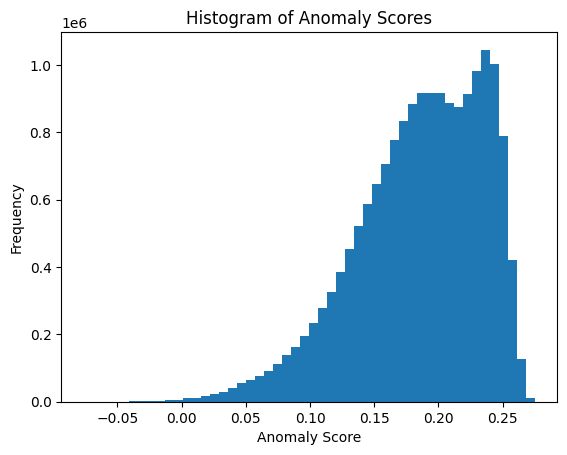

In [18]:
# Histogram of anomaly scores
plt.hist(data['anomaly_score'], bins=50)
plt.title('Histogram of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Free the memory space
del X_combined
gc.collect()

6201

## Synthetic Data Test

In [20]:
# Create a copy of the dataset to insert synthetic anomalies
data_synthetic = data.copy()

# Introduce anomalies (e.g., extremely high values for a particular feature)
data_synthetic.loc[0:1000, 'RS_E_InAirTemp_PC1'] = data_synthetic['RS_E_InAirTemp_PC1'].max() + 50

# Standardize and encode the synthetic dataset
X_numeric_scaled_synthetic = scaler.transform(data_synthetic[numeric_features])
X_categorical_encoded_synthetic = encoder.transform(data_synthetic[categorical_features])
X_combined_synthetic = np.hstack((X_numeric_scaled_synthetic, X_categorical_encoded_synthetic))

# Predict using the Isolation Forest model
synthetic_outliers = iso_forest.predict(X_combined_synthetic)

# Check if the synthetic anomalies are detected
print("Detection of Synthetic Anomalies:", synthetic_outliers[0:1000])

Detection of Synthetic Anomalies: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

true_labels = np.ones(len(data_synthetic), dtype=int)
true_labels[0:1000] = -1  

precision = precision_score(true_labels, synthetic_outliers, pos_label=-1)
recall = recall_score(true_labels, synthetic_outliers, pos_label=-1)
f1 = f1_score(true_labels, synthetic_outliers, pos_label=-1)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [22]:
# Free the memory space
del data_synthetic
del X_numeric_scaled_synthetic
del X_categorical_encoded_synthetic
del X_combined_synthetic
del synthetic_outliers
gc.collect()

0

## Statistics Analysis

In [23]:
# Separate the dataset into normal and anomalous data
normal_data = data[data['IF_outlier'] == 1]
anomalous_data = data[data['IF_outlier'] == -1]

# Selecting a few key features for statistical analysis
selected_features = ['RS_E_InAirTemp_PC1', 'RS_E_OilPress_PC1', 'RS_E_RPM_PC1', 'Speed', 'lat', 'lon']

# Computing summary statistics for these features
summary_normal = normal_data[selected_features].describe()
summary_anomalous = anomalous_data[selected_features].describe()

In [24]:
summary_normal

RS_E_InAirTemp_PC1  RS_E_OilPress_PC1  RS_E_RPM_PC1         Speed  \
count          17463518.0       1.746352e+07  1.746352e+07  1.746352e+07   
mean                  NaN                NaN           NaN           NaN   
std                   0.0                NaN           NaN  0.000000e+00   
min                  -5.5       4.284668e-01  6.667969e+00  0.000000e+00   
25%                  22.0       2.030000e+02  7.980000e+02  8.139648e-01   
50%                  32.0       2.410000e+02  8.010000e+02  2.292969e+00   
75%                  40.0       3.200000e+02  8.210000e+02  3.259766e+00   
max                 122.0       6.900000e+02  2.308000e+03  1.198125e+02   

                lat           lon  
count  1.746352e+07  1.746352e+07  
mean            NaN           NaN  
std    0.000000e+00  0.000000e+00  
min    5.000000e+01  3.570312e+00  
25%    5.078125e+01  3.710938e+00  
50%    5.100000e+01  3.869141e+00  
75%    5.109375e+01  4.539062e+00  
max    5.131250e+01  5.570312e+00

In [25]:
summary_anomalous

RS_E_InAirTemp_PC1  RS_E_OilPress_PC1  RS_E_RPM_PC1         Speed  \
count        1.747800e+04            17478.0      17478.00  1.747800e+04   
mean                  inf                inf           inf           inf   
std          9.898438e+00                inf           inf  3.475000e+01   
min         -5.000000e+00                1.5         35.25  5.021095e-04   
25%          6.000000e+00               17.0        798.00  2.773438e+00   
50%          1.100000e+01              472.0        800.00  2.973438e+01   
75%          1.800000e+01              552.0        803.00  6.710938e+01   
max          6.500000e+01              690.0       2023.00  1.176875e+02   

                lat           lon  
count  1.747800e+04  1.747800e+04  
mean            inf           inf  
std    3.251953e-01  5.561523e-01  
min    5.006250e+01  3.599609e+00  
25%    5.040625e+01  3.869141e+00  
50%    5.078125e+01  4.460938e+00  
75%    5.100000e+01  5.109375e+00  
max    5.131250e+01  5.539062e+00

## Visualization

In [26]:
data_mini = data.head(500000)

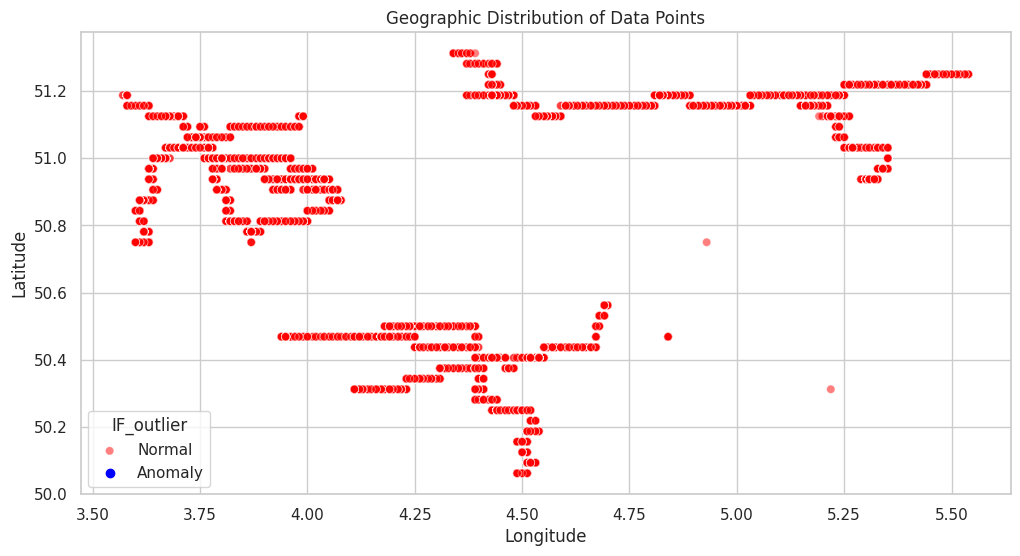

In [27]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# 1. Geographic Distribution
plt.figure(figsize=(12, 6))
sns.scatterplot(x='lon', y='lat', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Geographic Distribution of Data Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

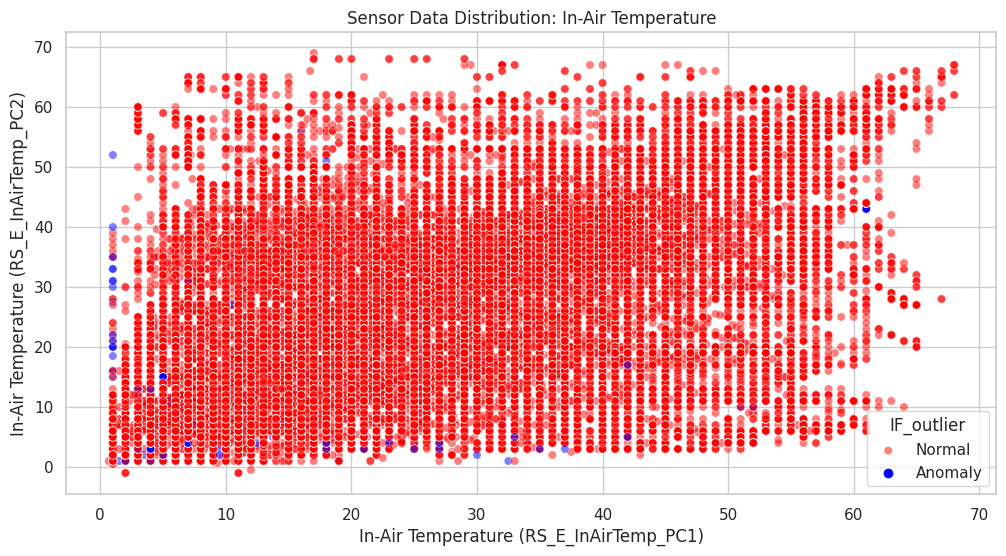

In [28]:
# 2. RS_E_InAirTemp
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_InAirTemp_PC1', y='RS_E_InAirTemp_PC2', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: In-Air Temperature')
plt.xlabel('In-Air Temperature (RS_E_InAirTemp_PC1)')
plt.ylabel('In-Air Temperature (RS_E_InAirTemp_PC2)')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


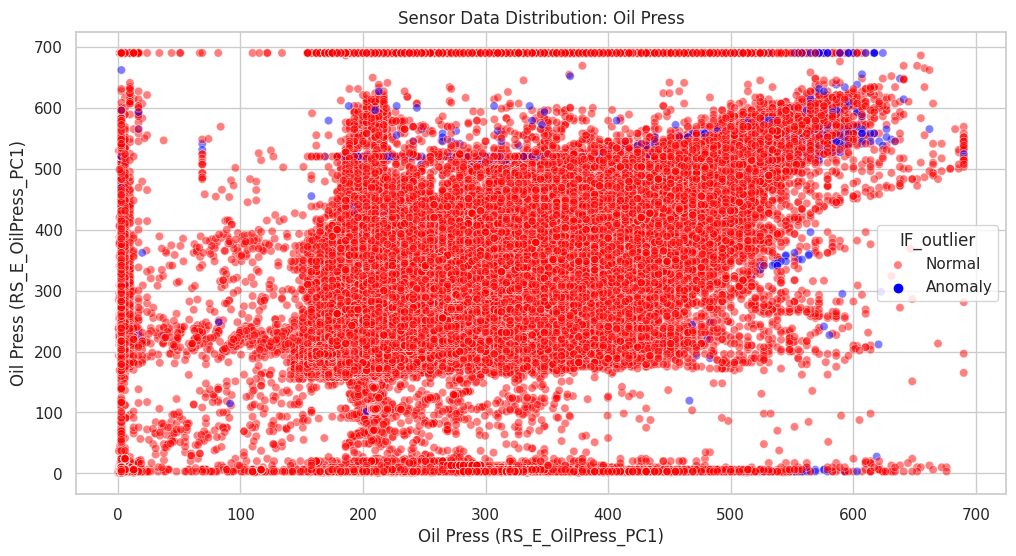

In [29]:
# 3. RS_E_OilPress
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_OilPress_PC1', y='RS_E_OilPress_PC2', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Press')
plt.xlabel('Oil Press (RS_E_OilPress_PC1)')
plt.ylabel('Oil Press (RS_E_OilPress_PC1)')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

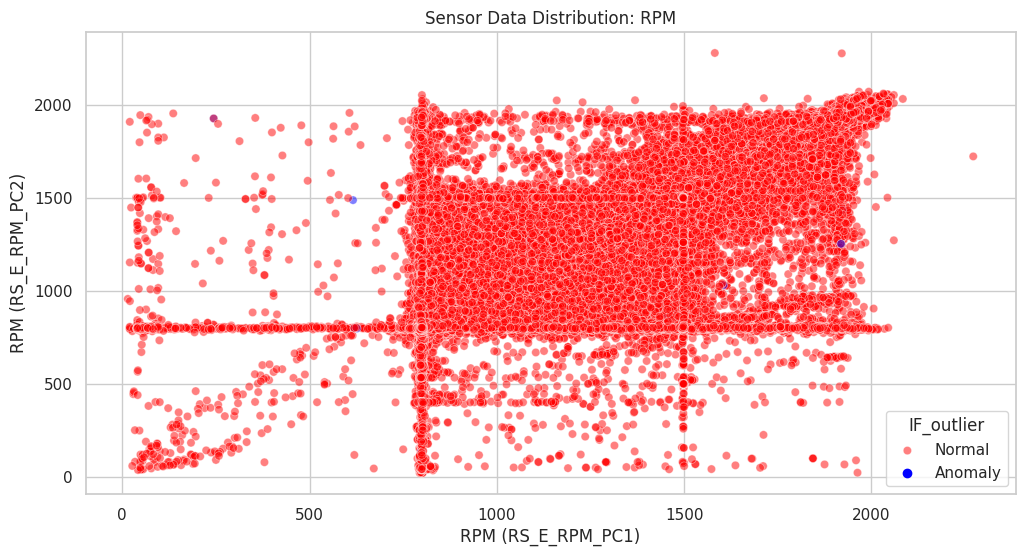

In [30]:
# 4. RS_E_RPM
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_RPM_PC1', y='RS_E_RPM_PC2', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: RPM')
plt.xlabel('RPM (RS_E_RPM_PC1)')
plt.ylabel('RPM (RS_E_RPM_PC2)')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


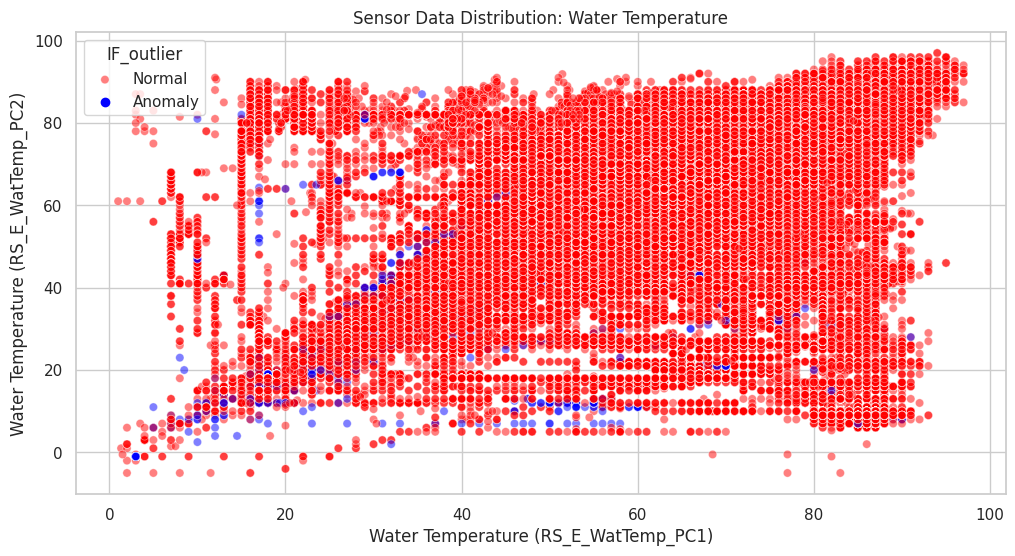

In [31]:
# 5. RS_E_WatTemp
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_WatTemp_PC1', y='RS_E_WatTemp_PC2', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Water Temperature')
plt.xlabel('Water Temperature (RS_E_WatTemp_PC1)')
plt.ylabel('Water Temperature (RS_E_WatTemp_PC2)')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

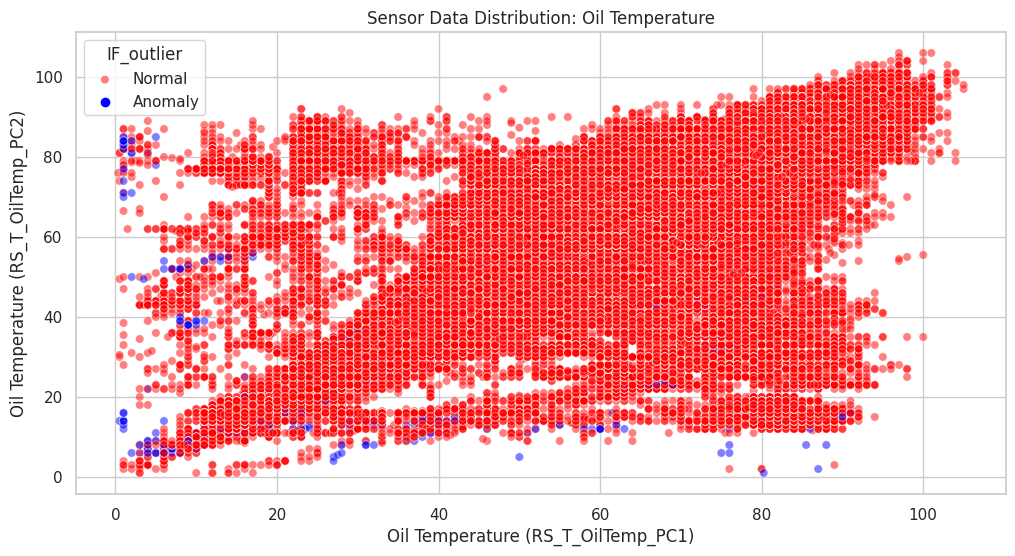

In [32]:
# 6. RS_T_OilTemp_PC1
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_T_OilTemp_PC1', y='RS_T_OilTemp_PC2', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Temperature')
plt.xlabel('Oil Temperature (RS_T_OilTemp_PC1)')
plt.ylabel('Oil Temperature (RS_T_OilTemp_PC2)')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

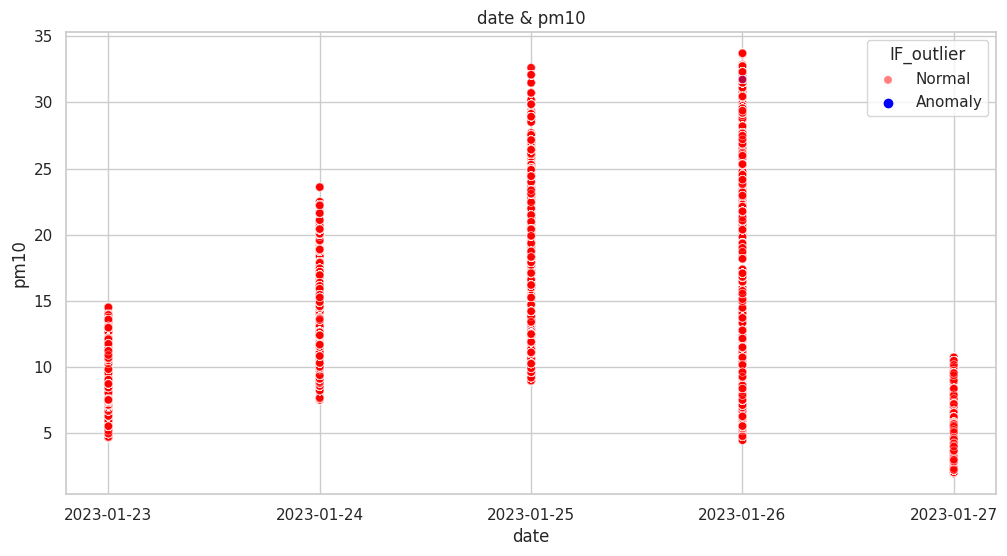

In [33]:
# 7. date & PM 10
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='pm10', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('date & pm10')
plt.xlabel('date')
plt.ylabel('pm10')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

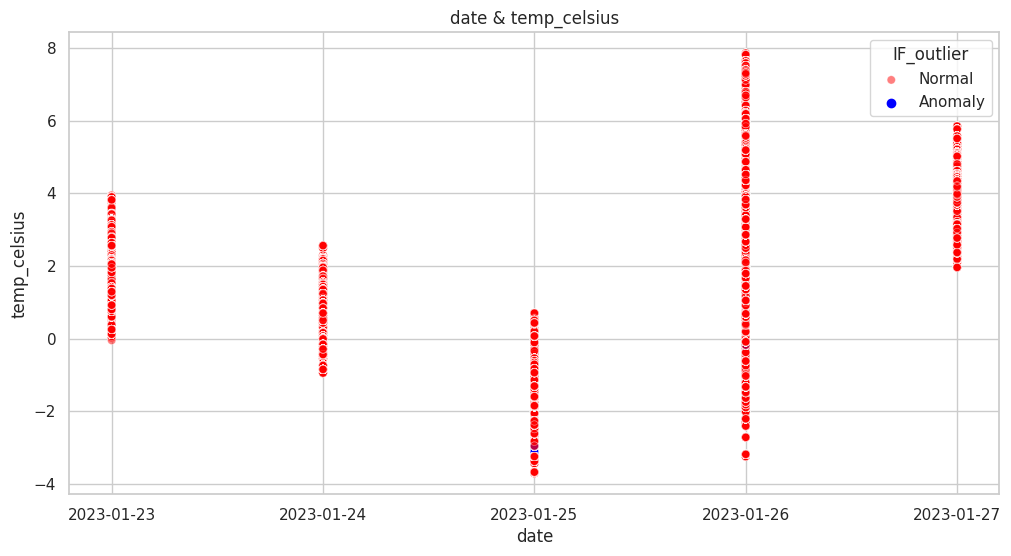

In [34]:
# 8. date & temp_celsius
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='temp_celsius', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('date & temp_celsius')
plt.xlabel('date')
plt.ylabel('temp_celsius')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

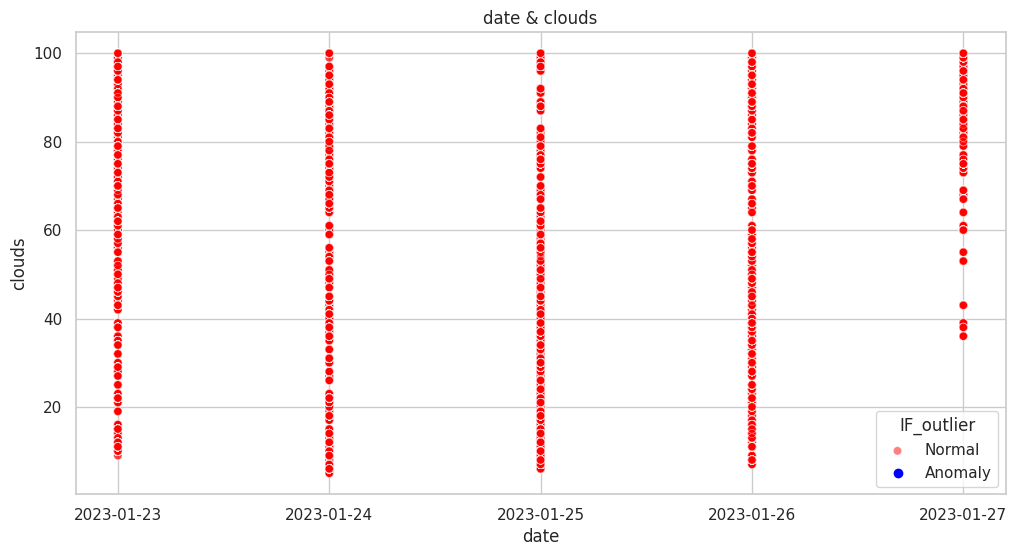

In [35]:
# 8. date & clouds
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='clouds', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('date & clouds')
plt.xlabel('date')
plt.ylabel('clouds')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

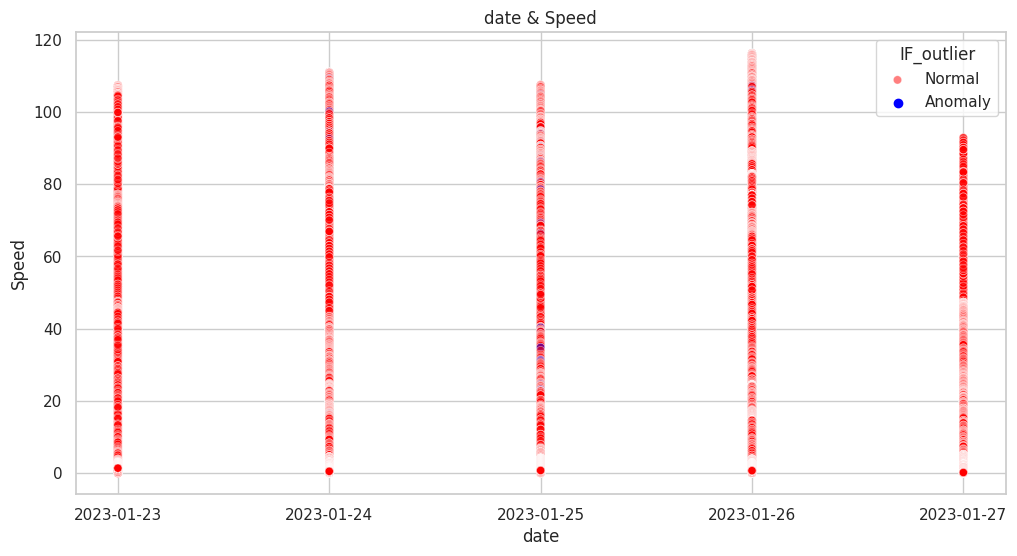

In [36]:
# 9. date & speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('date & Speed')
plt.xlabel('date')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

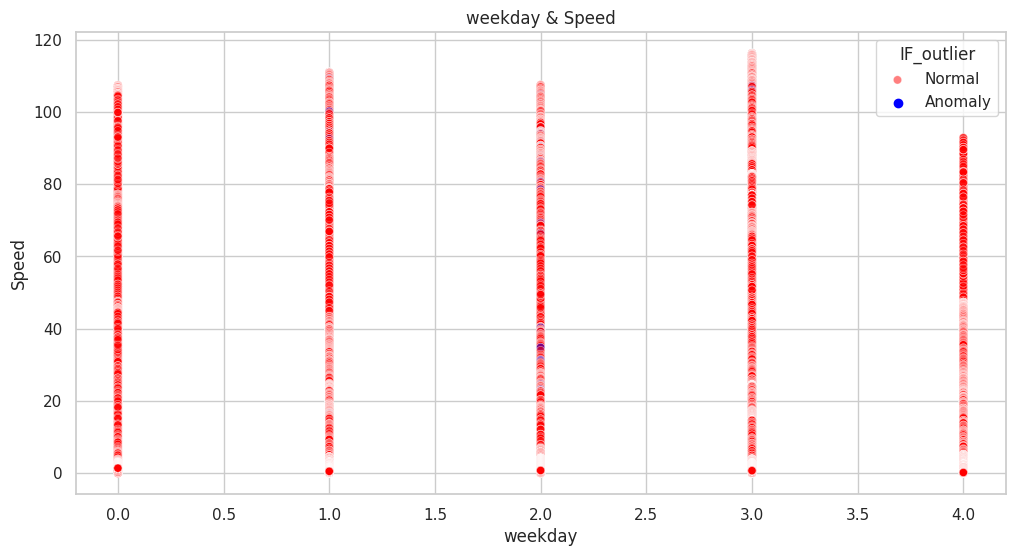

In [37]:
# 9. weekday & speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='weekday', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('weekday & Speed')
plt.xlabel('weekday')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

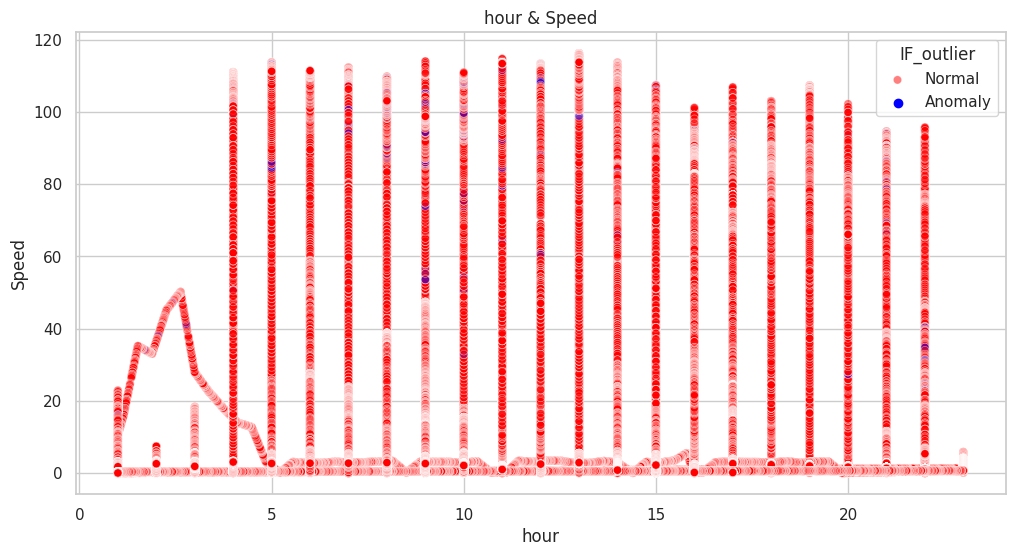

In [38]:
# 10. hour & speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hour', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('hour & Speed')
plt.xlabel('hour')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


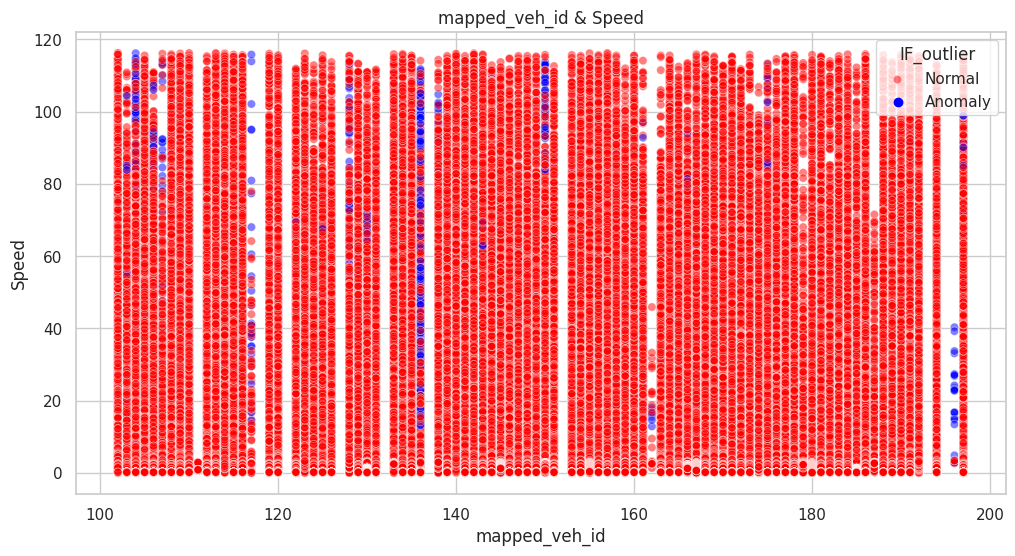

In [39]:
# 11. mapped_veh_id & speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='mapped_veh_id', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('mapped_veh_id & Speed')
plt.xlabel('mapped_veh_id')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

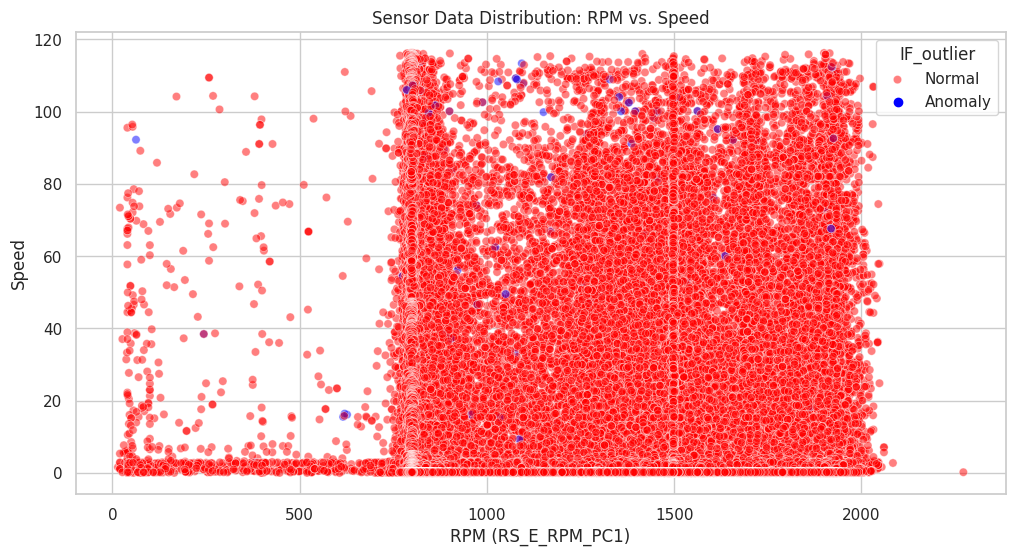

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


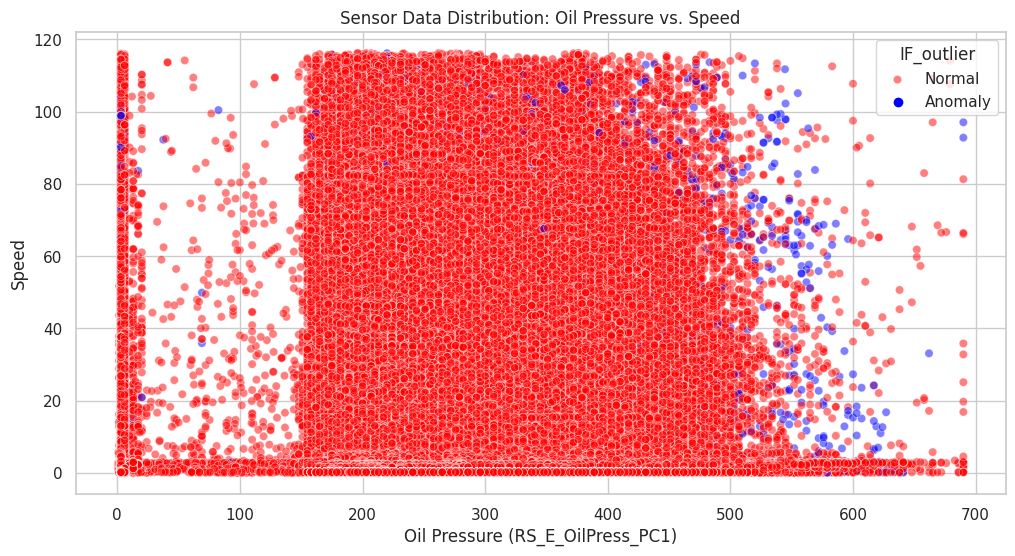

In [40]:
# 3. RPM vs. Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_RPM_PC1', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: RPM vs. Speed')
plt.xlabel('RPM (RS_E_RPM_PC1)')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

# 4. Oil Pressure vs. Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_OilPress_PC1', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Pressure vs. Speed')
plt.xlabel('Oil Pressure (RS_E_OilPress_PC1)')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

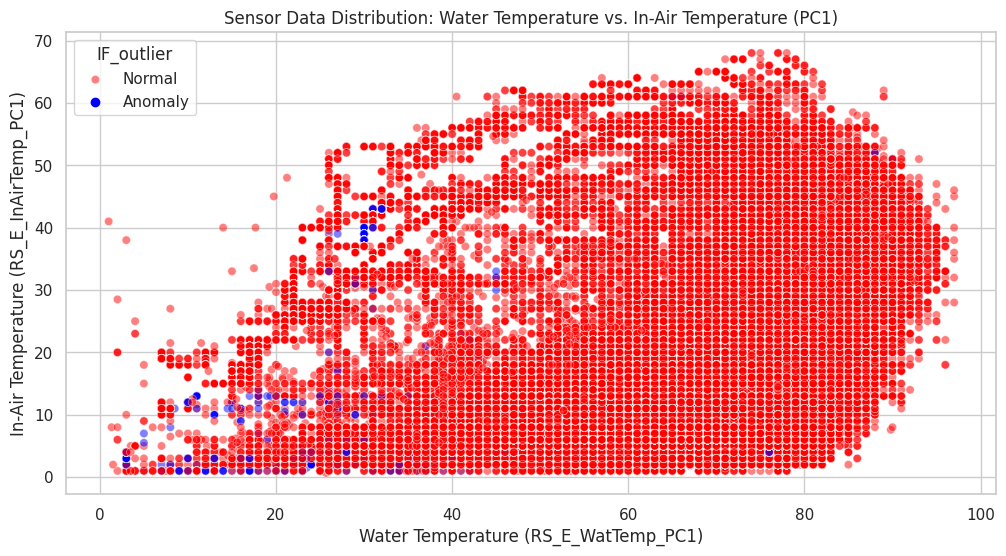

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


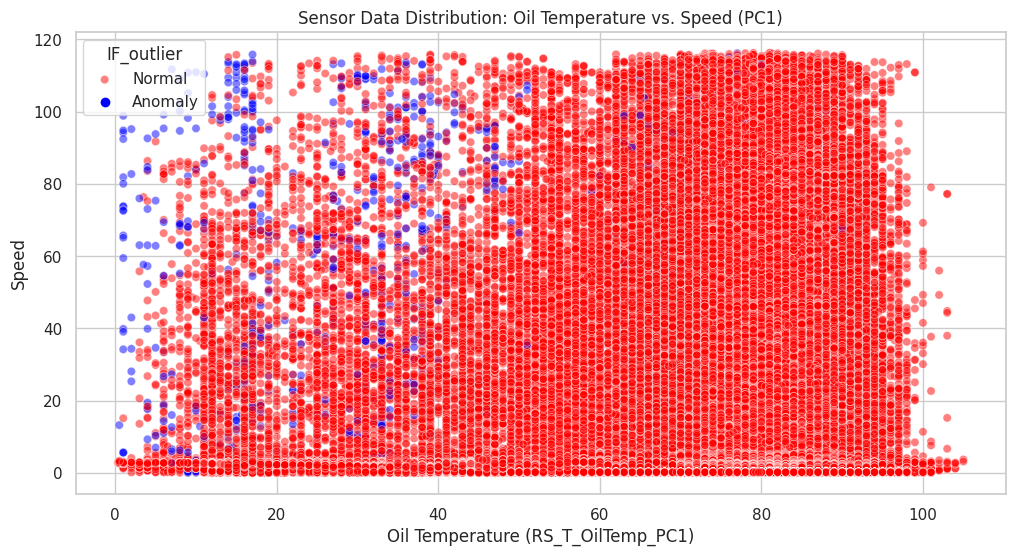

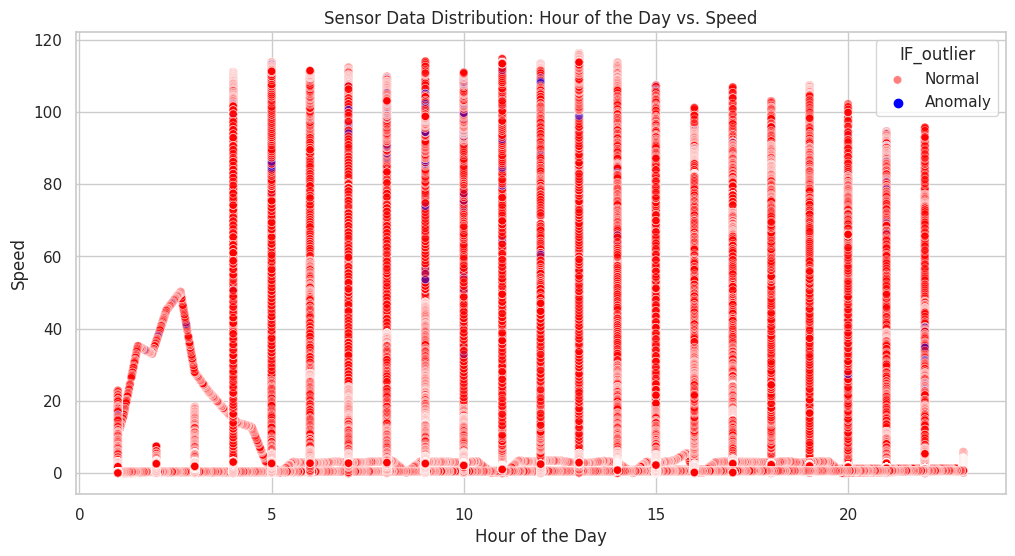

In [41]:
# 5. Water Temperature vs. In-Air Temperature (PC1)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_E_WatTemp_PC1', y='RS_E_InAirTemp_PC1', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Water Temperature vs. In-Air Temperature (PC1)')
plt.xlabel('Water Temperature (RS_E_WatTemp_PC1)')
plt.ylabel('In-Air Temperature (RS_E_InAirTemp_PC1)')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

# 6. Oil Temperature vs. Speed (PC1)
plt.figure(figsize=(12, 6))
sns.scatterplot(x='RS_T_OilTemp_PC1', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Oil Temperature vs. Speed (PC1)')
plt.xlabel('Oil Temperature (RS_T_OilTemp_PC1)')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

# 7. Hour of the Day vs. Speed
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hour', y='Speed', hue='IF_outlier', data=data_mini, palette=['blue', 'red'], alpha=0.5)
plt.title('Sensor Data Distribution: Hour of the Day vs. Speed')
plt.xlabel('Hour of the Day')
plt.ylabel('Speed')
plt.legend(title='IF_outlier', labels=['Normal', 'Anomaly'])
plt.show()

## Contextual Evaluation

In [42]:
# Define the temperature thresholds
thresholds = {
    'RS_E_InAirTemp_PC1': 65,  # Air temperature threshold in Celsius
    'RS_E_WatTemp_PC1': 100,  # Water temperature threshold in Celsius
    'RS_T_OilTemp_PC1': 115   # Oil temperature threshold in Celsius
}

# Filter the anomaly records
anomalous_records = data.loc[data['IF_outlier'] == -1, list(thresholds.keys()) + ['mapped_veh_id', 'timestamps_UTC']]

# Function to check if multiple temperatures are high
def check_multiple_high_temps(row, thresholds):
    high_temps = {temp: row[temp] > thresholds[temp] for temp in thresholds}
    # Count how many temperature readings are above the threshold
    high_temp_count = sum(high_temps.values())
    # Consider a true problem if more than one temperature reading is high
    return high_temp_count > 1

# Apply the function to each anomalous record
anomalous_records['multiple_high_temps'] = anomalous_records.apply(check_multiple_high_temps, axis=1, thresholds=thresholds)

# Filter records that are likely true problems
true_problems = anomalous_records[anomalous_records['multiple_high_temps']]

# Inspect the records classified as true problems
print(true_problems)

Empty DataFrame
Columns: [RS_E_InAirTemp_PC1, RS_E_WatTemp_PC1, RS_T_OilTemp_PC1, mapped_veh_id, timestamps_UTC, multiple_high_temps]
Index: []


In [43]:
data[(data['engine_error_label']==1) & (data['IF_outlier']==-1)]

timestamps_UTC  mapped_veh_id       lat       lon  \
4422761  2023-08-19 19:19:29          128.0  51.15625  4.898438   
4422762  2023-08-19 19:19:32          128.0  51.15625  4.898438   
4422763  2023-08-19 19:19:39          128.0  51.15625  4.898438   
4422764  2023-08-19 19:19:42          128.0  51.15625  4.898438   
4422765  2023-08-19 19:20:39          128.0  51.15625  4.890625   
4422766  2023-08-19 19:20:42          128.0  51.15625  4.890625   
12990878 2023-09-08 19:16:13          172.0  50.93750  5.320312   
12990879 2023-09-08 19:16:19          172.0  50.93750  5.320312   

          RS_E_InAirTemp_PC1  RS_E_InAirTemp_PC2  RS_E_OilPress_PC1  \
4422761                 31.0                88.0                6.0   
4422762                 31.0                88.0                6.0   
4422763                 31.0                88.0                6.0   
4422764                 31.0                88.0                6.0   
4422765                 31.0                88.0                6.0   
4422766                 31.0                88.0                6.0   
12990878                32.0                66.0                3.0   
12990879                32.0                66.0              296.0   

          RS_E_OilPress_PC2  RS_E_RPM_PC1  RS_E_RPM_PC2  ...      pm10  \
4422761                 3.0        1120.0        1220.0  ...  10.28125   
4422762                 3.0         828.0         825.0  ...  10.28125   
4422763                 3.0         795.0         795.0  ...  10.28125   
4422764                 3.0         800.0         799.5  ...  10.28125   
4422765                 3.0         999.5        1740.0  ...  10.03125   
4422766                 3.0        1201.0        1386.0  ...  10.03125   
12990878              169.0         806.0         803.0  ...  43.78125   
12990879              172.0        1149.0         794.0  ...  43.78125   

                nh3  time_diff  is_stopped stopped_group  \
4422761   10.890625   0.016663       False         12868   
4422762   10.890625   0.033325       False         12868   
4422763   10.890625   0.000000       False         12868   
4422764   10.890625   0.049988       False         12868   
4422765    8.867188   0.016663       False         12868   
4422766    8.867188   0.000000       False         12868   
12990878  16.093750   0.000000       False         14756   
12990879  16.093750   0.016663       False         14756   

          cumulative_stopped_time   status  engine_error_label  IF_outlier  \
4422761                  4.816406  running                   1          -1   
4422762                  4.867188  running                   1          -1   
4422763                  4.984375  running                   1          -1   
4422764                  5.035156  running                   1          -1   
4422765                  5.984375  running                   1          -1   
4422766                  6.035156  running                   1          -1   
12990878                 1.783203  running                   1          -1   
12990879                 1.883789  running                   1          -1   

         anomaly_score  
4422761      -0.000620  
4422762      -0.000620  
4422763      -0.002060  
4422764      -0.002060  
4422765      -0.000257  
4422766      -0.000257  
12990878     -0.000695  
12990879     -0.000982  

[8 rows x 47 columns]

# Save to CSV

In [44]:
data.to_csv('labeled_augumented_cleaned_ar41_for_ulb.csv', index=True)